<a href="https://colab.research.google.com/github/hudazama/CarvanaMasking/blob/master/CarvanaMasking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install kaggle --upgrade -q
!pip install imageio -q

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0


In [0]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import imageio
import matplotlib.pyplot as plt
import cv2

In [4]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hudazama","key":"df9c2b94daca0f51d36a6942835857f6"}'}

In [5]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#download Carvana competition data into colab
!kaggle competitions download -c carvana-image-masking-challenge 

 59% 9.00M/15.3M [00:00<00:00, 40.2MB/s]
100% 15.3M/15.3M [00:00<00:00, 50.7MB/s]
100% 801M/804M [00:06<00:00, 131MB/s]
100% 804M/804M [00:06<00:00, 139MB/s]
  0% 0.00/202k [00:00<?, ?B/s]
100% 202k/202k [00:00<00:00, 201MB/s]
100% 15.4G/15.4G [06:37<00:00, 39.1MB/s]
100% 15.4G/15.4G [06:37<00:00, 41.8MB/s]
100% 7.75G/7.76G [03:26<00:00, 39.1MB/s]
100% 7.76G/7.76G [03:26<00:00, 40.3MB/s]
  0% 0.00/107k [00:00<?, ?B/s]
100% 107k/107k [00:00<00:00, 111MB/s]
 31% 9.00M/29.1M [00:00<00:00, 34.2MB/s]
100% 29.1M/29.1M [00:00<00:00, 83.5MB/s]
  0% 0.00/81.2k [00:00<?, ?B/s]
100% 81.2k/81.2k [00:00<00:00, 52.1MB/s]
100% 404M/405M [00:06<00:00, 37.1MB/s]
100% 405M/405M [00:06<00:00, 64.7MB/s]


In [0]:
#unzip the training data
!unzip -q train.zip 
!unzip -q train_masks.zip 
!unzip -q train_masks.csv.zip 
!unzip -q metadata.csv.zip 
#!unzip -q train_hq.zip

In [7]:
train_csv = pd.read_csv('metadata.csv')
train_csv.head()

,id,year,make,model,trim1,trim2
0,0004d4463b50,2014.0,Acura,TL,TL,w/SE
1,00087a6bd4dc,2014.0,Acura,RLX,RLX,w/Tech
2,000aa097d423,2012.0,Mazda,MAZDA6,MAZDA6,i Sport
3,000f19f6e7d4,2016.0,Chevrolet,Camaro,Camaro,SS
4,00144e887ae9,2015.0,Acura,TLX,TLX,SH-AWD V6 w/Advance Pkg


Load & resize data, data augmentation 

In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# we create two instances with the same arguments
data_gen_args = dict(rescale=1./255,
                     rotation_range=90.,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True,
                     vertical_flip=True,
                     shear_range=0.2,
                     brightness_range=(0.5, 1.0),
                     validation_split=0.2
                    )
image_datagen = ImageDataGenerator(**data_gen_args)
mask_datagen = ImageDataGenerator(**data_gen_args)

In [0]:
def dice_coef(y_true, y_pred):
    y_true = tf.round(tf.reshape(y_true, [-1]))
    y_pred = tf.round(tf.reshape(y_pred, [-1]))
    isct = tf.reduce_sum(y_true * y_pred)
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

In [0]:
#split dataset
import os 
import glob
from sklearn.model_selection import train_test_split

train_mask = pd.read_csv('train_masks.csv')
filenames = train_mask['img']
train_filenames, val_test_filenames = train_test_split(filenames, test_size = 0.15)
val_filenames, test_filenames = train_test_split(val_test_filenames, test_size = 1/3)


In [0]:
os.makedirs('../content/data', exist_ok=True)
new_folders = ['training_images','training_masks','valid_images','valid_masks','test_images','test_masks']

for f in new_folders:
  os.makedirs('../content/data/' + f)
  os.makedirs('../content/data/' + f + '/0')


In [0]:
#Locate training, validation and testing images into respective folder
imagedir = '../content/train/'
maskdir = '../content/train_masks/' 
data_dir = '../content/data/'

for fname in train_filenames:
  os.rename(imagedir + fname, data_dir + 'training_images/0/' + fname)

for fname in val_filenames:
  os.rename(imagedir + fname, data_dir + 'valid_images/0/' + fname)

for fname in test_filenames:
  os.rename(imagedir + fname, data_dir + 'test_images/0/' + fname)

In [0]:
#Locate training, validation and testing masks into respective folder 

for fname in train_filenames:
  os.rename(maskdir + fname[:-4] + '_mask.gif', data_dir + 'training_masks/0/' + fname)

for fname in val_filenames:
  os.rename(maskdir + fname[:-4] + '_mask.gif', data_dir + 'valid_masks/0/' + fname)

for fname in test_filenames:
  os.rename(maskdir + fname[:-4] + '_mask.gif', data_dir + 'test_masks/0/' + fname)

In [92]:
import PIL
from PIL import Image
seed = 1
img_size = 256

image_args = dict(seed=seed,
    batch_size=32,
    shuffle=True,
    class_mode=None,
    target_size=(img_size, img_size),
    color_mode='rgb')

mask_args = dict(seed=seed,
    batch_size=32,
    class_mode=None,
    shuffle=True,
    target_size=(img_size, img_size), 
    color_mode='grayscale')

DIR = '/content/data/'
image = 'images'
masks = 'masks'

# combine generators into one which yields image and masks
train_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'training_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'training_'+masks))

validation_generator = zip(image_datagen.flow_from_directory(**image_args, directory=DIR+'valid_'+image),  
                      mask_datagen.flow_from_directory(**mask_args, directory=DIR+'valid_'+masks))

Found 4324 images belonging to 1 classes.
Found 4324 images belonging to 1 classes.
Found 509 images belonging to 1 classes.
Found 509 images belonging to 1 classes.


In [0]:
img1, mask1 = next(validation_generator)

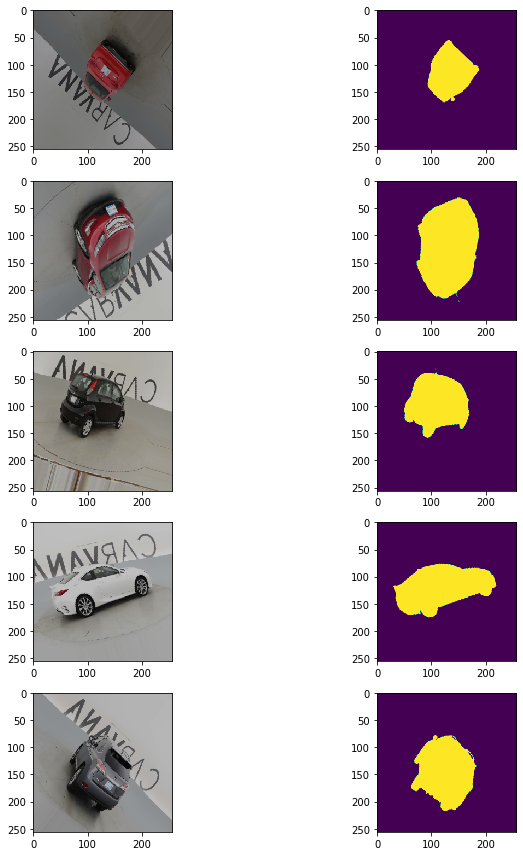

In [94]:
fig=plt.figure(figsize=(12,12))
columns = 2
rows = 5
counter = 0
c = 0
for i in range(1, columns*rows +1):
    #img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    if counter%2 == 0:
        plt.imshow(img1[c])
    else:
        plt.imshow(mask1[c][:,:,0])
        c = c + 1
    counter = counter + 1
    

plt.tight_layout()
plt.savefig('augmented.png')
plt.show()

UNET

In [0]:
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Lambda, RepeatVector, Reshape, MaxPooling2D, concatenate
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from tensorflow.keras import backend as K

In [0]:
# Provide the same seed and keyword arguments to the fit and flow methods
seed = 1
img_size = 256
im_width = 256
im_height = 256
im_chan = 3

In [98]:
# Build U-Net model
input_img = Input((im_height, im_width, im_chan), name='img')

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (input_img)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)


c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[input_img], outputs=[outputs])
model.compile(optimizer= 'adam', loss='binary_crossentropy', metrics=[dice_coef]) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 8)  224         img[0][0]                        
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 8)  584         conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 8)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [0]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=5,
                           verbose=1,
                           min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss',
                               factor=0.1,
                               patience=4,
                               verbose=1),
             ModelCheckpoint(monitor='val_loss',
                             filepath='weights/best_weights.hdf5',
                             save_best_only=True,
                             save_weights_only=True),
             TensorBoard(log_dir='./logs/logs_1e-4')]


In [0]:
results = Model.fit_generator(train_generator, steps_per_epoch=135, epochs=15, validation_data=validation_generator, validation_steps=16, callbacks=callbacks)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 135 steps, validate for 16 steps
Epoch 1/15
 62/135 [============>.................] - ETA: 2:29 - loss: 0.4888 - dice_coef: 0.0123